## 1. Problem Definition

### Objective

Breast Cancer is one of the most prevelant and dangerous forms of cancer worldwide. Early detection and accurate diagnosis are critical for improving survival rates. The goal of this project is to predict whether a breast tumor is malignant (cancerous) or benign (non-cancerous) based on different measurements of breast cancer cells. This dataset used in this project is the [Wisconsin Breast Cancer](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data) dataset from Kaggle.

### Metrics

Since this is a medical classification problem, the primary focus is to correctly identify malignant tumors, as failing to do so could have serious consequences. As such, recall will be the key performance metric for this project.

## 2. Data Preperation

### Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report


### Data Collection

In [2]:
# read the data
breast_data = pd.read_csv('data.csv')

# seperate the data and labels
labels = breast_data['diagnosis']
breast_data.drop(columns=['id', 'Unnamed: 32', 'diagnosis'], inplace=True)

1. Add Labeling into its own category.
2. Removing 'id' and 'Unnamed: 32' columns since they don't provide any information. 

In [3]:
breast_data.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Data Cleaning

**Checking for missing data**

In [4]:
breast_data.info()
print(format(breast_data.isnull().values.any()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

There are no missing values found in the data

**Checking For Duplicates**

In [5]:
duplicated_rows = breast_data[breast_data.duplicated()]
print(duplicated_rows)

Empty DataFrame
Columns: [radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave points_worst, symmetry_worst, fractal_dimension_worst]
Index: []

[0 rows x 30 columns]


There are no duplicated rows found in the dataset.

**Categorical Label Encoding**

In [6]:
def diagnosis_value(diagnosis):
    if diagnosis == 'M': return 1
    return 0

# encode the labels
labels =  labels.apply(diagnosis_value)

We label 1 as a malignant tumor and 0 as a benign tumor.

**Checking Class Imbalance**

In [7]:
malignant_count = labels.sum()
benign_count = labels.count() - malignant_count
print("There are {} malignant tumors.".format(malignant_count))
print("There are {} benign tumors.".format(benign_count))
print("The Imbalance Ratio is {:.1f}%.".format((malignant_count / benign_count)*100))

There are 212 malignant tumors.
There are 357 benign tumors.
The Imbalance Ratio is 59.4%.


Considering the Imbalance Ratio is only moderately imbalanced and not severe, we should be aware this may lead to bias in our model, but for now, we will leave it as is and address it if necessary later.

## 3. FEATURE ENGINEERING

**Feature Scaling**
- Z-Score Normalization

In [8]:
# Z-score normalize each feature
for col in breast_data.columns:
    breast_data[col] = (breast_data[col] - breast_data[col].mean()) / breast_data[col].std()

In [9]:
breast_data.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,...,5.690000e+02,5.690000e+02,5.690000e+02,569.000000,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,-1.311195e-16,6.243785e-17,-1.248757e-16,-2.185325e-16,-8.366672e-16,1.998011e-16,3.746271e-17,-4.995028e-17,1.748260e-16,4.838933e-16,...,-8.241796e-16,1.248757e-17,-3.496520e-16,0.000000,-2.122887e-16,-3.621395e-16,8.741299e-17,2.122887e-16,2.622390e-16,-5.744282e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.027864e+00,-2.227289e+00,-1.982759e+00,-1.453164e+00,-3.109349e+00,-1.608721e+00,-1.113893e+00,-1.260710e+00,-2.741705e+00,-1.818265e+00,...,-1.725382e+00,-2.222039e+00,-1.691872e+00,-1.221348,-2.680337e+00,-1.442609e+00,-1.304683e+00,-1.743529e+00,-2.159060e+00,-1.600431e+00
25%,-6.887793e-01,-7.253249e-01,-6.913472e-01,-6.666089e-01,-7.103378e-01,-7.464292e-01,-7.430941e-01,-7.372951e-01,-7.026215e-01,-7.220040e-01,...,-6.743279e-01,-7.479711e-01,-6.889721e-01,-0.641571,-6.906227e-01,-6.804845e-01,-7.558491e-01,-7.557349e-01,-6.412994e-01,-6.913035e-01
50%,-2.148925e-01,-1.045442e-01,-2.357726e-01,-2.949274e-01,-3.486040e-02,-2.217454e-01,-3.419391e-01,-3.973715e-01,-7.156354e-02,-1.781226e-01,...,-2.688030e-01,-4.347738e-02,-2.857288e-01,-0.340881,-4.680159e-02,-2.692639e-01,-2.180402e-01,-2.232725e-01,-1.272975e-01,-2.162538e-01
75%,4.689800e-01,5.836621e-01,4.992377e-01,3.631877e-01,6.356397e-01,4.934227e-01,5.255994e-01,6.463664e-01,5.303125e-01,4.705693e-01,...,5.215568e-01,6.577623e-01,5.398040e-01,0.357275,5.970195e-01,5.391944e-01,5.306742e-01,7.118836e-01,4.497425e-01,4.503661e-01
max,3.967796e+00,4.647799e+00,3.972634e+00,5.245913e+00,4.766717e+00,4.564409e+00,4.239858e+00,3.924477e+00,4.480808e+00,4.906602e+00,...,4.090590e+00,3.882489e+00,4.283568e+00,5.924959,3.951897e+00,5.108382e+00,4.696536e+00,2.683516e+00,6.040726e+00,6.840837e+00


Since KNN works off Euclidean distances, we scale the data in a Z-score normalization to ensure that no feature dominates another and place everything on the same scale.

**Feature Reduction w/ PCA**

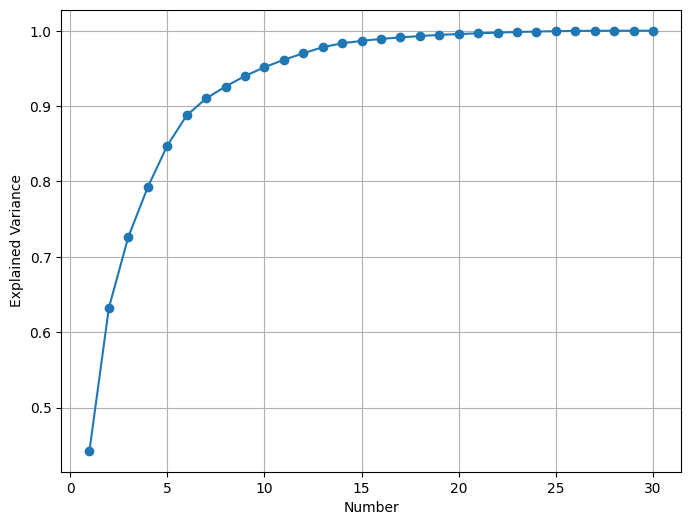

Number of components for 80% variance: 5
Number of components for 95% variance: 10


In [10]:
pca = PCA(n_components=len(breast_data.columns))
principal_components = pca.fit_transform(breast_data)

# calculate the cumulative explained variance
cev = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(breast_data.columns) + 1), cev, marker='o')
plt.xlabel('Number')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()

print("Number of components for 80% variance: {}".format((cev >= .8).argmax() + 1))
print("Number of components for 95% variance: {}".format((cev >= .95).argmax() + 1))


Considering we can achieve 80% of the variance with 5 features and the accuracy & recall gained is not significant, we carry on with 5 features for the model.

In [11]:
# create dataframe with 5 most principal components
pca = PCA(n_components=5)
principal_components = pca.fit_transform(breast_data)

pca_df = pd.DataFrame(data=principal_components, columns=['PC{}'.format(i+1) for i in range(5)])

**Correlation Matrix**

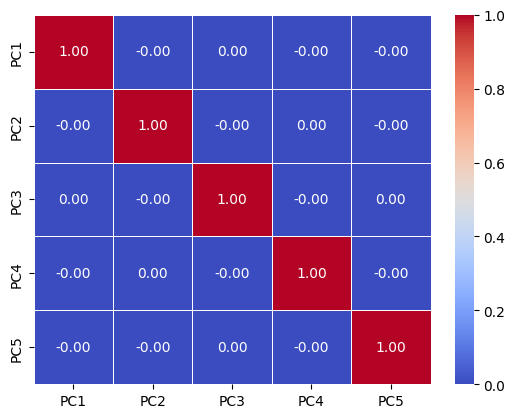

In [12]:
corr_matrix = pca_df.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

Using the correlation matrix, we can see that each feature contributes its own variance  allowing to capture distinct patterns without correlation between feature.

## 4. Model Selection & Grid Search

In [13]:
# split the data in X and y 
X = np.array(pca_df)
y = np.array(labels)

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=12)

In [14]:
# set parameters for the grid search
param_grid = {
    'n_neighbors': [x for x in range(3, 30)], 
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

# execute and fit grid search
grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# print out best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}


## 5. Model Creation and Fitting

In [15]:
# create model with best parameters and fit
knn = grid_search.best_estimator_
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=4, weights='distance')

## 6. Results

In [16]:
# get predicted variables
y_pred = knn.predict(X_test)

# make classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96        66
           1       0.98      0.90      0.93        48

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.95       114
weighted avg       0.95      0.95      0.95       114



Given the classification report, we can see that the precision and recall are high indicating the model was able to accurately find differences and classify the tumors correctly.

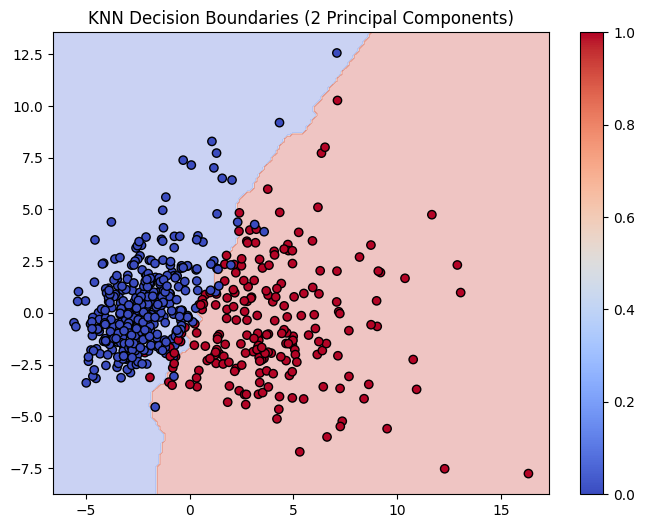

In [17]:
xx, yy = np.meshgrid(np.linspace(pca_df['PC1'].min() - 1, pca_df['PC1'].max() + 1, 200),
                     np.linspace(pca_df['PC2'].min() - 1, pca_df['PC2'].max() + 1, 200))

grid_points = np.c_[xx.ravel(), yy.ravel()]

median_PC3 = pca_df['PC3'].median()
median_PC4 = pca_df['PC4'].median()
median_PC5 = pca_df['PC5'].median()

grid_points_5D = np.hstack([grid_points, 
                             np.full((grid_points.shape[0], 3), [median_PC3, median_PC4, median_PC5])])

Z = knn.predict(grid_points_5D).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=y, edgecolors='k', cmap='coolwarm')
plt.title("KNN Decision Boundaries (2 Principal Components)")
plt.colorbar()
plt.show()


## 7. Conclusion

The K-Nearest Neighbor classifier demonstrated a high performance in predicting breast cancer tumors. With an accuracy of 95% and a recall of 90% for malignant tumors, it showed that it can effectively identify cancerous tumors while minimizing the risk of false negative results. 

The decision boundary visualization helps illustrate how well the model seperates malignant and benign tumors. The results help explain how PCA and KNN can be a reliable approach to create a successfull model that utilizes less dimensions making it quick and reliable for cancer detection in clinical settings.